## Importing libraries

In [1]:
import numpy as np
from matplotlib import image
import matplotlib.pyplot as plt
from scipy import signal
import cv2 as cv
from skimage.feature import peak_local_max

## Reading images

In [2]:
pat = image.imread('patch.png').astype(np.float32)
main_img = image.imread('Greek-ship.jpg').astype(np.float32)

In [3]:
print(pat.shape, main_img.shape)

(485, 211, 3) (3024, 4032, 3)


In [4]:
print((main_img.min(), main_img.max()), (pat.min(), pat.max()))

(0.0, 255.0) (0.1254902, 0.85882354)


## Visualization

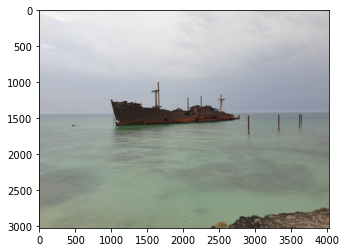

In [5]:
plt.imshow(main_img/main_img.max());

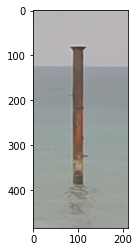

In [6]:
plt.imshow(pat);

## Utility functions

- Normalizing image pixel intensities between 0 and 1

In [7]:
def normalize_between_zero_to_one(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

def change_range_between_zero_to_one(arr):
    arr[arr > 1] = 1
    arr[arr < 0] = 0

    return arr

In [8]:
main_img, pat = normalize_between_zero_to_one(main_img), normalize_between_zero_to_one(pat)

- Downscale

In [9]:
def downscale(img, factor=2):
    return img[::factor, ::factor, :]

In [10]:
d_img = downscale(main_img, 8)
d_pat = downscale(pat, 8)

print(d_img.shape, d_pat.shape)

(378, 504, 3) (61, 27, 3)


- Draw rectangles

In [11]:
def draw_rectangles(img, coords: list, sizes, figs=(10, 10)):
    plt.figure(figsize=figs)
    plt.imshow(img)
    for i, (x, y) in enumerate(coords):
        rect = plt.Rectangle((y, x), sizes[1], sizes[0], color='r', fc='none')
        plt.gca().add_patch(rect);
    plt.show();

- Edge detection

In [12]:
def get_edge_img_single_channel(img):
    x_filter = np.array([
        [1, 0, -1],
        [2, 0, -2],
        [1, 0, -1],
    ])
    y_filter = x_filter.T
    
    result_x = signal.convolve2d(img, x_filter, mode='valid')
    result_y = signal.convolve2d(img, y_filter, mode='valid')
    edge_img = np.sqrt(result_x**2 + result_y**2)
    edge_img = edge_img * img.max() / edge_img.max()
    
    return edge_img


def get_edge_img(img):
    res = np.stack([get_edge_img_single_channel(img[:, :, i]) for i in range(3)], axis=-1)
    return normalize_between_zero_to_one(res).astype(np.float32)

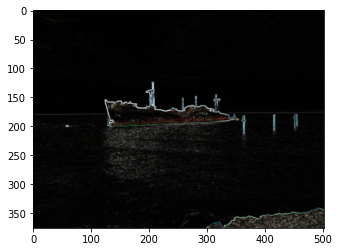

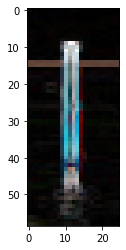

In [13]:
d_img_edge = get_edge_img(d_img)
d_pat_edge = get_edge_img(d_pat)

plt.imshow(d_img_edge)
plt.show()
plt.imshow(d_pat_edge);

## Using library

### Template matching on original images

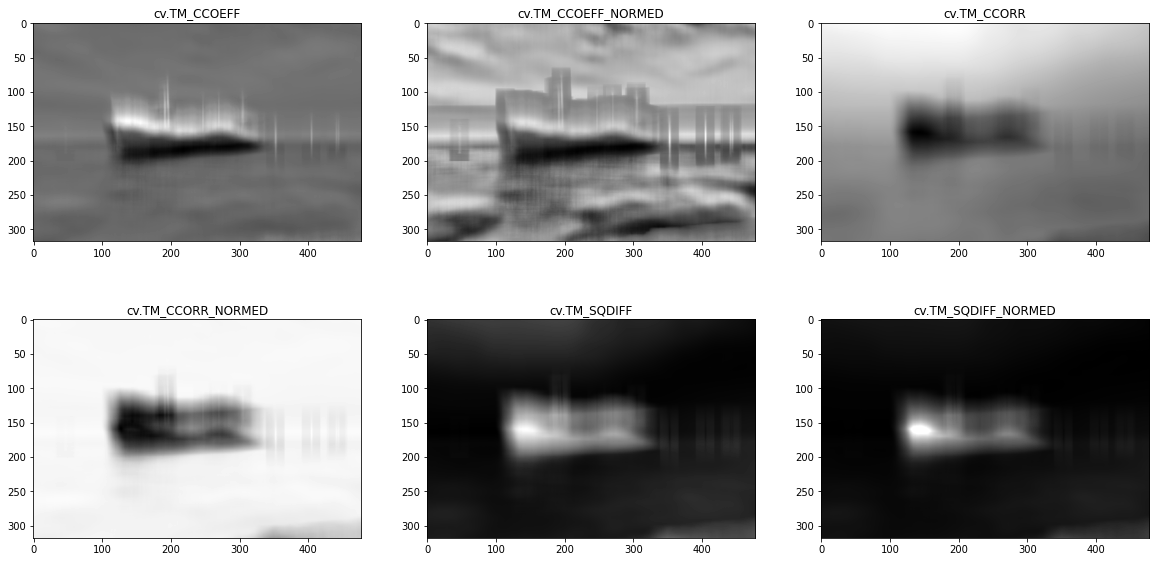

In [14]:
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR', 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i, method in enumerate(methods):
    result = cv.matchTemplate(d_img, d_pat, eval(method))
    axs[i//3, i%3].imshow(result, cmap='gray')
    axs[i//3, i%3].set_title(method)

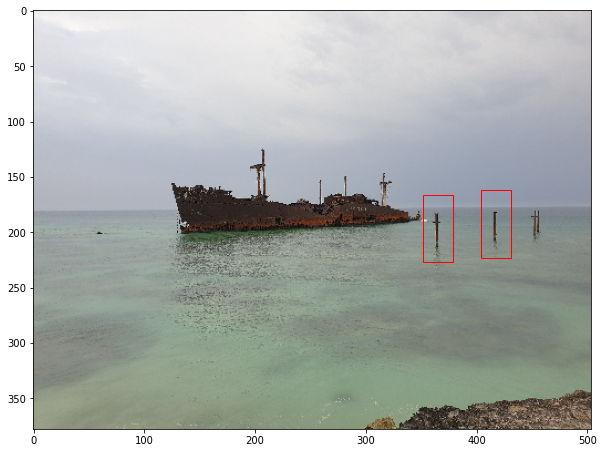

In [15]:
result = cv.matchTemplate(d_img, d_pat, cv.TM_CCOEFF_NORMED)
draw_rectangles(d_img, peak_local_max(result, threshold_abs=0.70, min_distance=10), d_pat.shape[:2])

It's not bad, but if we try to lower the threshold to get the third one in the water, it breaks!!!

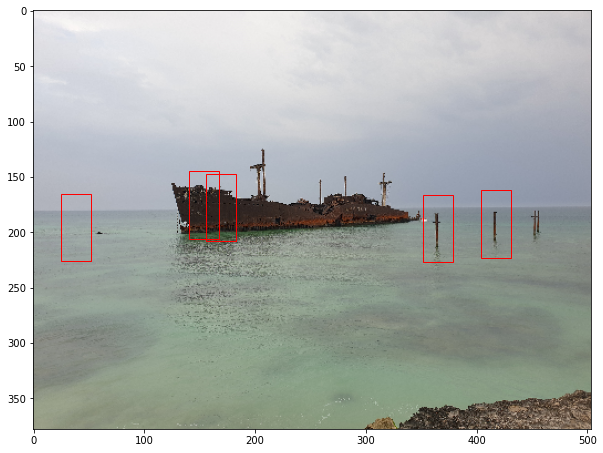

In [16]:
result = cv.matchTemplate(d_img, d_pat, cv.TM_CCOEFF_NORMED)
draw_rectangles(d_img, peak_local_max(result, threshold_abs=0.61, min_distance=10), d_pat.shape[:2])

So It's better to do this on edges...

### Template matching on edges images

We use different methods that OpenCV provides us with for template matching. After choosing the best among them, we implement it.

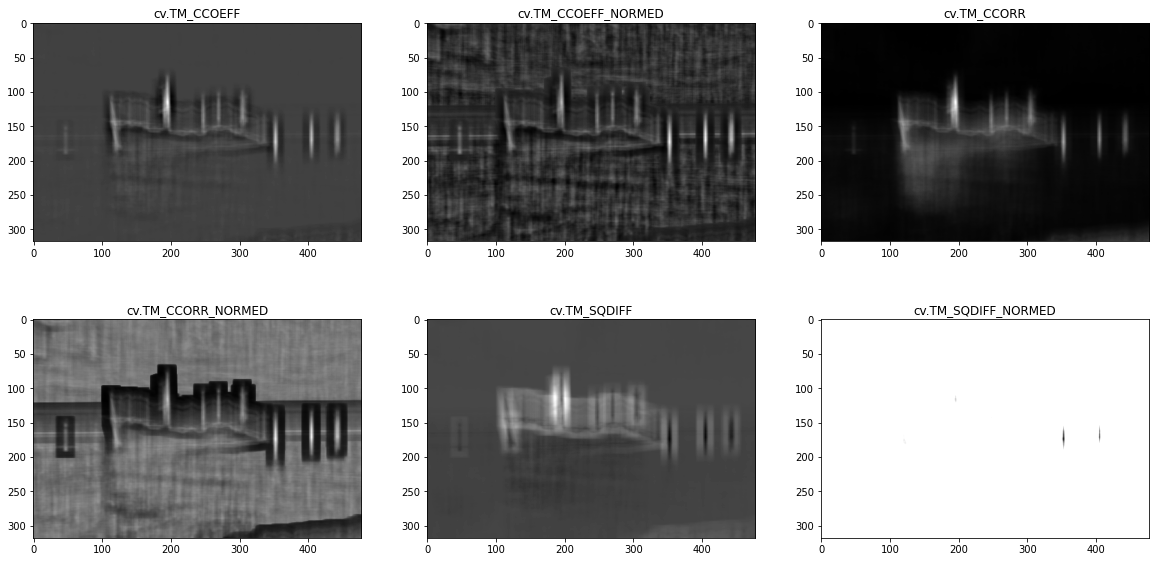

In [17]:
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR', 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
for i, method in enumerate(methods):
    result = cv.matchTemplate(d_img_edge, d_pat_edge, eval(method))
    axs[i//3, i%3].imshow(result, cmap='gray')
    axs[i//3, i%3].set_title(method)

In [18]:
result = cv.matchTemplate(d_img_edge, d_pat_edge, cv.TM_CCOEFF_NORMED)

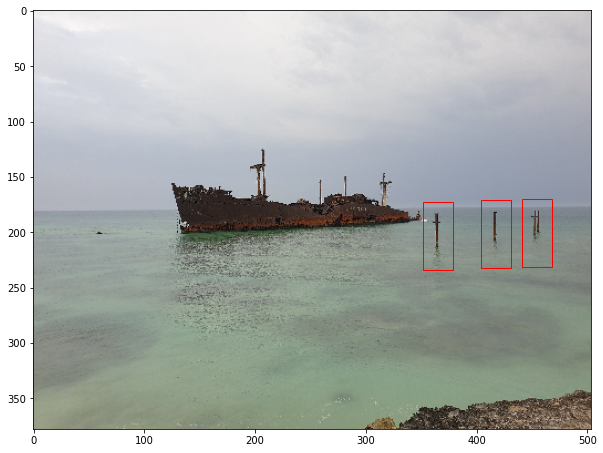

In [19]:
draw_rectangles(d_img, peak_local_max(result, threshold_abs=0.55, min_distance=10), d_pat.shape[:2])

## Implementation without library

Normalized Cross Correlation

![NCC](NCC.png)

In [21]:
def NCC(image, template):
    i_range, j_range = template.shape

    h = np.zeros((image.shape[0]-i_range, image.shape[1]-j_range))

    t_diff = (template-template.mean());
    t_diff_sum_square = np.sum(t_diff**2)

    for i in range(h.shape[0]):
        for j in range(h.shape[1]):
            f = image[i:i+i_range, j:j+j_range]
            f_diff = f - f.mean()
            f_diff_sum_square = np.sum(f_diff**2)
            h[i, j] = np.sum(t_diff * f_diff) / np.sqrt(t_diff_sum_square * f_diff_sum_square)
    
    return normalize_between_zero_to_one(h)

In [22]:
result = NCC(d_img_edge.mean(axis=2), d_pat_edge.mean(axis=2))

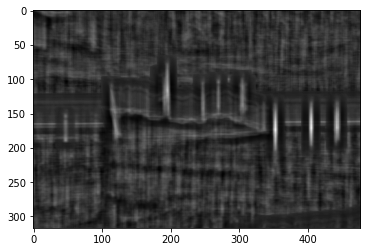

In [23]:
plt.imshow(result, cmap='gray');

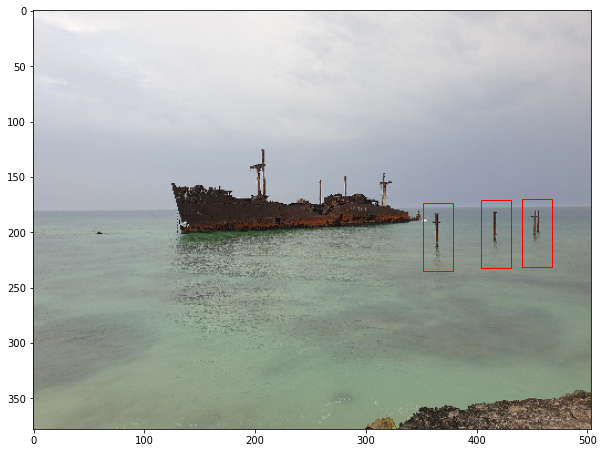

In [24]:
draw_rectangles(d_img, peak_local_max(result, threshold_abs=0.80, min_distance=10), d_pat.shape[:2])

Ok, we see that it's working properly. Now it's time to build a pyramid structure to achieve this result in the original resolution.

## Image Pyramid

This function searches for a better match in the boundry of the given coordinate.

In [25]:
def local_search_rectangle(img, template, coord, boundry):
    i_range, j_range = template.shape[:2]
    
    i_s, i_e = max(0, coord[0]-boundry), min(coord[0]+i_range+boundry, img.shape[0])
    j_s, j_e = max(0, coord[1]-boundry), min(coord[1]+j_range+boundry, img.shape[1])
    local_img = img[i_s:i_e, j_s:j_e]

    result = NCC(get_edge_img(local_img).mean(axis=2), get_edge_img(template).mean(axis=2))
    match_coord = np.unravel_index(result.argmax(), result.shape)

    return match_coord[0]+i_s, match_coord[1]+j_s

Pyramid search

In [26]:
def pyramid_search(img, template, num_levels=4, search_boundry=10):
    if num_levels == 1:
        result = NCC(get_edge_img(img).mean(axis=2), get_edge_img(template).mean(axis=2))
        coords = peak_local_max(result, threshold_abs=0.80, min_distance=10)    
        draw_rectangles(img, coords, template.shape[:2], (num_levels*3+3, num_levels*3+3))

        return coords
    
    coords = pyramid_search(
        downscale(img, factor=2),
        downscale(template, factor=2),
        num_levels-1,
        search_boundry
    )*2
    
    for i in range(coords.shape[0]):
        coords[i] = local_search_rectangle(img, template, coords[i], search_boundry)

    draw_rectangles(img, coords, template.shape[:2], (num_levels*3+3, num_levels*3+3))
    return coords

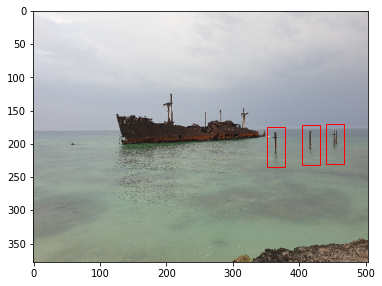

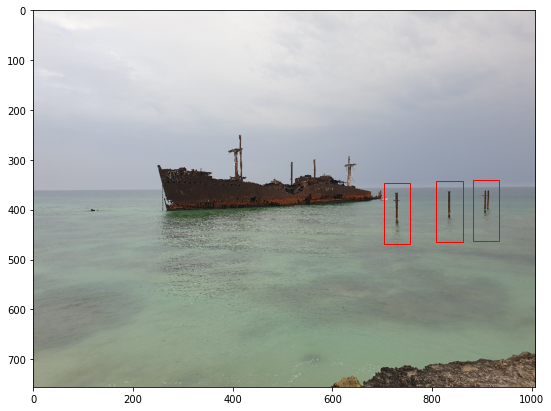

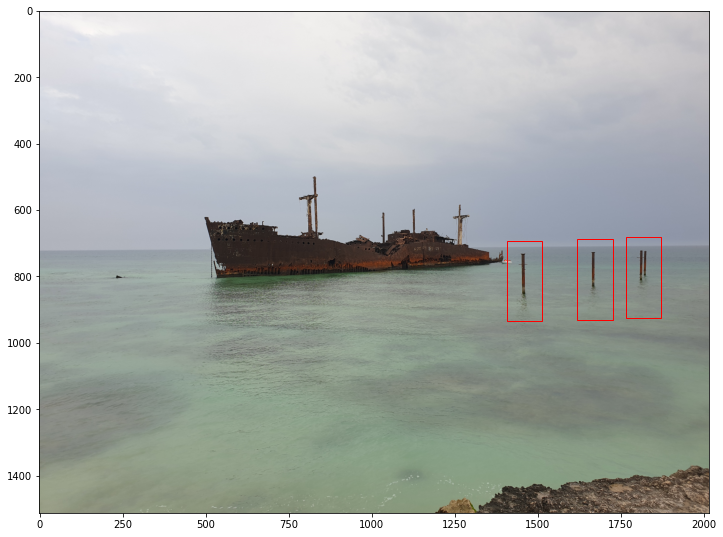

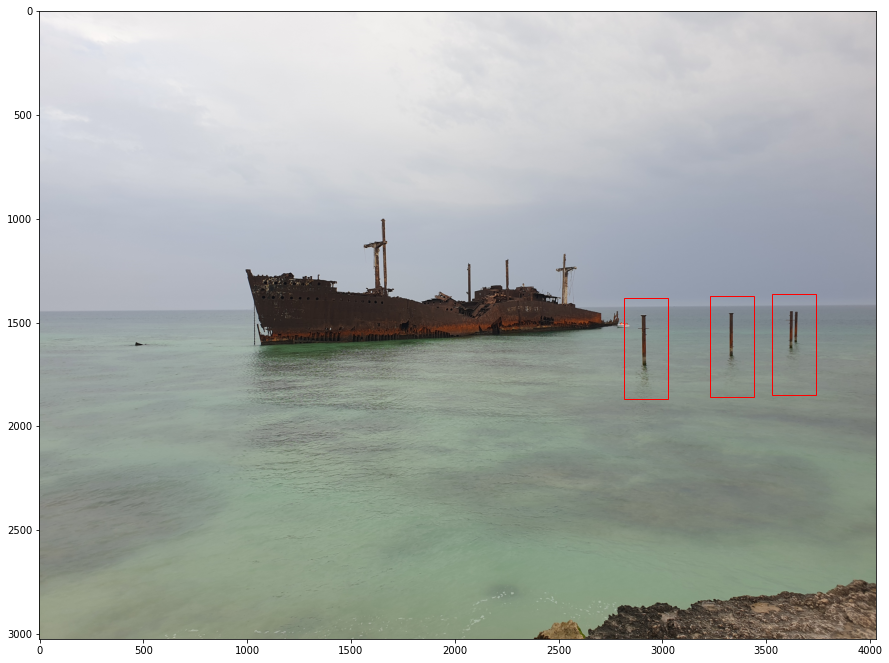

In [29]:
coords = pyramid_search(main_img, pat, num_levels=4, search_boundry=10)